To run this jupyter-notebook, please make sure you are using python 3.8 and see the packages in the requirements.txt.

This file describes the experimental implementation for the whole-graph (our baseline 1) on Hetionet, 
including set-up phase (mostly the same as the Compactwalk.ipynb file), 
running phase for the use case 1, 2, and 3, and Figure 3 (Deepwalk-whole).
The purpose to separate the whole-graph part is because 
(1) the functions (same procedures) are a bit different;
(2) the loading process for the whole-graph is different;
(3) the loading time is much longer than SS and NS.

# Setup phase
## Packages Installation

In [39]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from lark import Lark, Transformer, v_args
import time

import os
import networkx as nx
import numpy as np
import pandas as pd

from gensim.models import Word2Vec
from stellargraph.data import BiasedRandomWalk, UniformRandomWalk, UniformRandomMetaPathWalk
from stellargraph import StellarGraph
from stellargraph import datasets
from IPython.display import display, HTML

from stellargraph import StellarGraph, StellarDiGraph
import os
import py2neo
from py2neo import Graph
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, metrics
from sklearn.metrics.cluster import normalized_mutual_info_score#, rand_score
# %matplotlib inline

import stellargraph
import tensorflow.random

from scipy import interpolate
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans

## Load the whole graph for Hetionet

In [2]:
# Create the Neo4j Graph database object; the parameters can be edited to specify location and authentication
G = Graph('bolt://neo4j.het.io/')

In [5]:
labelled_edges = G.run(
    """
    MATCH (s) -[r]-> (t)
    RETURN s.name AS source, t.name AS target, type(r) AS label
    """
).to_data_frame()

labelled_edges

,source,target,label
0,respiratory system,IQGAP3,EXPRESSES_AeG
1,liver,IQGAP3,EXPRESSES_AeG
2,brain,IQGAP3,EXPRESSES_AeG
3,pancreas,IQGAP3,EXPRESSES_AeG
4,embryo,IQGAP3,EXPRESSES_AeG
...,...,...,...
2250192,MLH1,somatic diversification of immune receptors vi...,PARTICIPATES_GpBP
2250193,PMS2,somatic diversification of immune receptors vi...,PARTICIPATES_GpBP
2250194,VPRBP,somatic diversification of immune receptors vi...,PARTICIPATES_GpBP
2250195,PRKDC,somatic diversification of immune receptors vi...,PARTICIPATES_GpBP


In [8]:
types = list(G.schema.node_labels)

raw_nodes = {}
for i in types:
    query = """
    MATCH (n:{})
    RETURN n.name AS name
    """.format(i)   #, labels(n)
    print(query, 'raw_{}_nodes'.format(i))
    
    raw_nodes[i] = G.run(query).to_data_frame().drop_duplicates()


    MATCH (n:BiologicalProcess)
    RETURN n.name AS name
     raw_BiologicalProcess_nodes

    MATCH (n:PharmacologicClass)
    RETURN n.name AS name
     raw_PharmacologicClass_nodes

    MATCH (n:Symptom)
    RETURN n.name AS name
     raw_Symptom_nodes

    MATCH (n:Gene)
    RETURN n.name AS name
     raw_Gene_nodes

    MATCH (n:Compound)
    RETURN n.name AS name
     raw_Compound_nodes

    MATCH (n:SideEffect)
    RETURN n.name AS name
     raw_SideEffect_nodes

    MATCH (n:CellularComponent)
    RETURN n.name AS name
     raw_CellularComponent_nodes

    MATCH (n:Pathway)
    RETURN n.name AS name
     raw_Pathway_nodes

    MATCH (n:Anatomy)
    RETURN n.name AS name
     raw_Anatomy_nodes

    MATCH (n:MolecularFunction)
    RETURN n.name AS name
     raw_MolecularFunction_nodes

    MATCH (n:Disease)
    RETURN n.name AS name
     raw_Disease_nodes


In [10]:
import pandas as pd
nodes = {}
for i in types:
    nodes[i] = pd.DataFrame(index=raw_nodes[i]["name"])
nodes[i]

""
name
bile duct cancer
Crohn's disease
pancreatic cancer
polycystic ovary syndrome
nicotine dependence
...
hypothyroidism
malaria
adrenal gland cancer


In [11]:
# see all nodes
df = pd.DataFrame()#(index="name")
for i in types:
    df = pd.concat([df, nodes[i]],axis=0)
df

""
name
ripoptosome assembly
negative regulation of lipid metabolic process
positive regulation of smooth muscle cell proliferation
extracellular matrix disassembly
dendrite regeneration
...
hypothyroidism
malaria
adrenal gland cancer


In [12]:
df = pd.DataFrame() # culmulated
filter_nodes = {}
for i in types:
    if i == "Gene":
        filter_nodes[i] = nodes[i]
    else:
        filter_nodes[i] = nodes[i][~nodes[i].index.isin(df.index)]

    df = pd.concat([df, nodes[i]],axis=0)
    df = df[~df.index.duplicated(keep='first')]
df

""
name
ripoptosome assembly
negative regulation of lipid metabolic process
positive regulation of smooth muscle cell proliferation
extracellular matrix disassembly
dendrite regeneration
...
hypothyroidism
malaria
adrenal gland cancer


In [13]:
# Read the whole-graph from Hetionet
heterogeneous_nodes = StellarDiGraph(filter_nodes, edges = labelled_edges, edge_type_column="label")
print(heterogeneous_nodes.info())

StellarDiGraph: Directed multigraph
 Nodes: 46897, Edges: 2250197

 Node types:
  Gene: [20943]
    Features: none
    Edge types: Gene-COVARIES_GcG->Gene, Gene-INTERACTS_GiG->Gene, Gene-PARTICIPATES_GpBP->BiologicalProcess, Gene-PARTICIPATES_GpCC->CellularComponent, Gene-PARTICIPATES_GpMF->MolecularFunction, ... (4 more)
  BiologicalProcess: [11381]
    Features: none
    Edge types: none
  SideEffect: [5625]
    Features: none
    Edge types: SideEffect-ASSOCIATES_DaG->Gene, SideEffect-DOWNREGULATES_DdG->Gene, SideEffect-LOCALIZES_DlA->Anatomy, SideEffect-PRESENTS_DpS->Symptom, SideEffect-RESEMBLES_DrD->Disease, ... (1 more)
  MolecularFunction: [2884]
    Features: none
    Edge types: none
  Pathway: [1807]
    Features: none
    Edge types: none
  Compound: [1546]
    Features: none
    Edge types: Compound-BINDS_CbG->Gene, Compound-CAUSES_CcSE->PharmacologicClass, Compound-CAUSES_CcSE->SideEffect, Compound-CAUSES_CcSE->Symptom, Compound-DOWNREGULATES_CdG->Gene, ... (7 more)
  Cel

## Functions to Generate Random Walks and Embeddings for the whole-graph 
### (baseline 1)

In [23]:
#Generates random walks for various methods.
def getWalks(G, node_list, method, l, r, metapath = None):
    Walks = []
    for node in node_list:
        # DeepWalk
        if method == 'deepwalk':
            rw = UniformRandomWalk(G) #BiasedRandomWalk(G)
            walks = rw.run(
                nodes= [node],#list(G.nodes()),  # root nodes
                length = l,#adj_wlength,  # maximum length of a random walk
                n = r #,  # number of random walks per root node
                #seed = 1
            )

        # Node2Vec
        elif method == 'node2vec':
            rw = BiasedRandomWalk(G)
            walks = rw.run(
                nodes= [node],  # root nodes
                length = l,  # maximum length of a random walk
                n = r,  # number of random walks per root node
                p = 0.25,  # Defines (unormalised) probability, 1/p, of returning to source node
                q = 0.25#,  # Defines (unormalised) probability, 1/q, for moving away from source node
                #seed = 5
            )

        #Metapath2vec
        elif method == 'metapath2vec':
            rw = UniformRandomMetaPathWalk(G)
            walks = rw.run(
                nodes= [node],#list(G.nodes()),  # root nodes
                length = l,  # maximum length of a random walk
                n = r,  # number of random walks per root node
                metapaths = metapath#,
                #seed = 5
            )

        # append walks
        for w in walks:
            Walks.append(w)
            
    return Walks

# Generates a model with embeddings from provided collection of Walks.
def buildModel(Walks):
    str_walks = [[str(n) for n in walk] for walk in Walks]
    model = Word2Vec(str_walks, size=128, window=10, min_count=0, sg=1, workers=2, iter=5)
    return model

In [17]:
def evaluate(model, node_list1, node_list2):
    evaluate_dict = {}
    hit_at_1_in_list = 0
    hit_at_3_in_list = 0
    hit_at_5_in_list = 0
    mrr_in_list = 0
    node_list = node_list1 + node_list2
    for n in node_list1:
        n2 = n
        n_all = 0
        num_in_list = 0
        rank_in_list = 0
        for i in model.wv.most_similar(n2, topn = 20000):
            n_all += 1

            if i[0] in node_list:
                num_in_list += 1
                
            if i[0] == node_list2[node_list1.index(n)]:      
                # test: include only drugs in list
                rank_in_list = num_in_list
                if rank_in_list == 1:
                    hit_at_1_in_list += 1
                if rank_in_list <= 3:
                    hit_at_3_in_list += 1
                if rank_in_list <= 5:
                    hit_at_5_in_list += 1
                mrr_in_list += 1/rank_in_list

    HIT1 = round(hit_at_1_in_list/len(node_list1),4)
    HIT3 = round(hit_at_3_in_list/len(node_list1),4)
    HIT5 = round(hit_at_5_in_list/len(node_list1),4)
    MRR = round(mrr_in_list/len(node_list1),4)

    evaluate_dict['HIT@1'] = HIT1
    evaluate_dict['HIT@3'] = HIT3
    evaluate_dict['HIT@5'] = HIT5
    evaluate_dict['MRR'] = MRR

    return evaluate_dict

# Experiment
## Use case 1 -- Drug Clustering
We perform cluster analysis for drugs in use case 1. 
To better implement the process, we created a function -- "Clustering" to 
conduct the process iteratively and directly output the average NMI. 
We can see the results of SS (our approach) and NS (our baseline 2) in "Compactwalk.ipynb".

In [19]:
## process of experiment use case 1 to compute average NMI
def Clustering(G, node_list, label_true, m, metapath = None):
    NMI = []
    for i in range(0,10): # the times you want to run can be altered here
        Walks = getWalks(G, node_list, m, 80, 20, metapath)
        model = buildModel(Walks)
        # Retrieve node embeddings and corresponding subjects
        node_ids = model.wv.index2word  # list of node IDs
        node_embeddings = (model.wv.vectors)    

        # clustering
        elist = []
        for i in node_list:
            elist.append(node_embeddings[node_ids.index(i)])
        node_embeddings_drug = np.array(elist)
        X = node_embeddings_drug
        kmeans_fit = cluster.KMeans(n_clusters = 10).fit(X)
        cluster_labels = kmeans_fit.labels_
        label_pred = cluster_labels
        nmi = normalized_mutual_info_score(label_true, label_pred)
        NMI.append(nmi)
        
    return round(sum(NMI)/len(NMI),4)

In [20]:
## Hetionet (Drug) 
# given G, node_List, embedding method(m), walk_length(l), num_walk(r), 
# given metapath {if metapath2vec is used}   

# G = the database link
G = "bolt://neo4j.het.io" 

# node_list = a list of nodes of interest
node_list = ['Dexamethasone', 'Betamethasone', 'Hydrocortisone', 'Mometasone',
'Canagliflozin', 'Dapagliflozin', 
'Lapatinib', 'Afatinib', 'Erlotinib', 'Gefitinib',
'Captopril', 'Enalapril', 'Benazepril', 'Lisinopril',
'Losartan', 'Valsartan', 'Telmisartan', 'Irbesartan',
'Nifedipine', 'Felodipine', 'Amlodipine', 'Nicardipine',
'Simvastatin', 'Atorvastatin', 'Fluvastatin', 'Lovastatin',
'Alendronate', 'Incadronate', 'Zoledronate',
'Citalopram', 'Escitalopram', 'Fluoxetine', 'Paroxetine', 'Sertraline',
'Fluconazole', 'Voriconazole', 'Itraconazole', 'Ketoconazole']

label_true = [0,0,0,0,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,8,8,8,8,8,9,9,9,9] 

# True node-pairs to evaluate
node_pair1 = ['Canagliflozin', 'Dexamethasone','Lapatinib', 
                'Captopril','Losartan', 'Nifedipine', 
                'Simvastatin', 'Alendronate', 'Citalopram']
node_pair2 = ['Dapagliflozin','Betamethasone','Afatinib',
                'Enalapril','Valsartan','Felodipine',
                'Atorvastatin','Incadronate','Escitalopram']

# metapaths {if metapath2vec is used}  
metapaths = [['Compound','Gene','Disease', 'Gene', 'Compound']]

In [26]:
G = heterogeneous_nodes
print("Drug clustering result for whole-graph on Hetionet:")
methods = ['deepwalk', 'node2vec', 'metapath2vec']
for m in methods:
    nmi = Clustering(G, node_list, label_true, m, metapath = metapaths)
    print("whole-"+ m, ":",nmi)

Drug clustering result for whole-graph on Hetionet:
whole-deepwalk : 0.5188
whole-node2vec : 0.5117
whole-metapath2vec : 0.4732


## Use Case 2 -- Drug Prediction

We perform link prediction for drug-pairs in use case 2. 
To better implement the process, we created a function -- "PairPrediction" to conduct the process 
iteratively and directly output the average MRR & Hits@k. 
We can see the results of SS (our approach) and NS (our baseline 2) in "Compactwalk.ipynb".

In [31]:
## process of experiment use case 2, 3 to compute average MRR & Hits@k
def PairPrediction(G, node_list, node_pair1, node_pair2, m, metapath = None):
    metrics = []
    average_dict = {}
    for i in range(0,10): # the times you want to run can be altered here
        Walks = getWalks(G, node_list, m, 80, 20, metapath)
        model = buildModel(Walks)
        # Retrieve node embeddings and corresponding subjects
        node_ids = model.wv.index2word  # list of node IDs
        node_embeddings = (model.wv.vectors)    
        mrr_hit = evaluate(model, node_pair1, node_pair2)        
        metrics.append(mrr_hit)
    
    HIT1 = round(sum(item.get('HIT@1',0) for item in metrics) / len(metrics),4)
    HIT3 = round(sum(item.get('HIT@3',0) for item in metrics) / len(metrics),4)
    HIT5 = round(sum(item.get('HIT@5',0) for item in metrics) / len(metrics),4)
    MRR = round(sum(item.get('MRR',0) for item in metrics) / len(metrics),4)
    
    average_dict['HIT@1'] = HIT1
    average_dict['HIT@3'] = HIT3
    average_dict['HIT@5'] = HIT5
    average_dict['MRR'] = MRR
        
    return average_dict

In [32]:
# drug pair prediction result for the whole-graph on Hetionet
print("Drug-pair prediction result for the whole-graph on Hetionet:")
methods = ['deepwalk', 'node2vec', 'metapath2vec']
for m in methods:
    metrics = PairPrediction(G, node_list, node_pair1, node_pair2, m, metapath = metapaths)
    print("whole-"+ m, ":",metrics)

Drug-pair prediction result for the whole-graph on Hetionet:
whole-deepwalk : {'HIT@1': 0.2666, 'HIT@3': 0.4, 'HIT@5': 0.5778, 'MRR': 0.4126}
whole-node2vec : {'HIT@1': 0.2333, 'HIT@3': 0.3889, 'HIT@5': 0.5, 'MRR': 0.3792}
whole-metapath2vec : {'HIT@1': 0.0667, 'HIT@3': 0.2222, 'HIT@5': 0.3333, 'MRR': 0.2196}


## Use Case 3 -- Disease Prediction

We perform link prediction for disease-pairs in use case 2. 
Same as use case 2, we use "PairPrediction" to conduct the process and output the average MRR & Hits@k. 
We can see the results of SS (our approach) and NS (our baseline 2) in "Compactwalk.ipynb".

In [33]:
## Hetionet (Disease)
# given node_List, embedding method(m), walk_length(l), num_walk(r), 
# given compared_labels {only for database includes multiple labels for nodes}, 
# given metapath {if metapath2vec is used}   

# node_list = a list of nodes of interest
node_list = ["hypertension","coronary artery disease",
"endogenous depression","panic disorder",
"schizophrenia",
"endogenous depression",
"pancreatic cancer","lung cancer",
"breast cancer","ovarian cancer",
"bipolar disorder","endogenous depression",
"stomach cancer","prostate cancer",
"migraine","epilepsy syndrome"]

# metapaths {if metapath2vec is used}   
metapaths = [['Disease', 'Gene', 'Compound', 'Gene', 'Disease']]

# True node-pairs to evaluate
node_pair1 = ["hypertension","endogenous depression","schizophrenia","endogenous depression","pancreatic cancer",
              "breast cancer","bipolar disorder","bipolar disorder","stomach cancer","migraine"]


node_pair2 = ["coronary artery disease","panic disorder","panic disorder","panic disorder","lung cancer",
              "ovarian cancer","endogenous depression","panic disorder","prostate cancer","epilepsy syndrome"] 

In [35]:
# disease pair prediction result for the whole-graph on Hetionet
print("Disease-pair prediction result for the whole-graph on Hetionet:")
G = heterogeneous_nodes
methods = ['deepwalk', 'node2vec', 'metapath2vec']
for m in methods:
    metrics = PairPrediction(G, node_list, node_pair1, node_pair2, m, metapath = metapaths)
    print("whole-"+ m, ":",metrics)


Disease-pair prediction result for the whole-graph on Hetionet:
whole-deepwalk : {'HIT@1': 0.2, 'HIT@3': 0.32, 'HIT@5': 0.46, 'MRR': 0.34}
whole-node2vec : {'HIT@1': 0.2, 'HIT@3': 0.26, 'HIT@5': 0.44, 'MRR': 0.3275}
whole-metapath2vec : {'HIT@1': 0.05, 'HIT@3': 0.26, 'HIT@5': 0.46, 'MRR': 0.2419}


# Figures
## Figure 3 (Deepwalk-whole)

In [41]:
def ClusteringDF(G, node_list, label_true):
    Walks = getWalks(G, node_list, 'deepwalk', 80, 20, None)
    model = buildModel(Walks)
    # Retrieve node embeddings and corresponding subjects
    node_ids = model.wv.index2word  # list of node IDs
    node_embeddings = (model.wv.vectors)  

    # Apply t-SNE transformation on node embeddings and find corresponding embeddings for each node
    tsne = TSNE(n_components=2, random_state = 1)
    node_embeddings_2d = tsne.fit_transform(node_embeddings)
    elist = []
    for i in node_list:
        elist.append(node_embeddings_2d[node_ids.index(i)])
    node_embeddings_drug_2d = np.array(elist)

    # clustering
    X = node_embeddings_drug_2d
    df = pd.DataFrame(X, columns=['d1','d2'])

    # k means
    kmeans = KMeans(n_clusters=10, random_state = 1)
    df['cluster'] = kmeans.fit_predict(X)
    df['label_true'] = label_true

    # get centroids
    centroids = kmeans.cluster_centers_
    cen_x = [i[0] for i in centroids] 
    cen_y = [i[1] for i in centroids]

    ## add to df
    df['cen_x'] = df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3], 4:cen_x[4], 5:cen_x[5], 
                                  6:cen_x[6], 7:cen_x[7], 8:cen_x[8], 9:cen_x[9]})
    df['cen_y'] = df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3], 4:cen_x[4], 5:cen_x[5], 
                                  6:cen_x[6], 7:cen_x[7], 8:cen_x[8], 9:cen_x[9]})
    return df

def tSNEplot(df, Node_Lists):
    fig = plt.figure()
    ax = plt.subplot(111)
    # draw the points
    MFC = ['r', 'none', 'g', 'none', 'c', 'none', 'y', 'none', 'C1', 'none']
    markers = ['ro', 'ko', 'gs', 'ks', 'c^', 'k^', 'y*', 'k*', 'C1d', 'kd']

    X = np.array(df[['d1','d2']])
    for i, nodes in enumerate(Node_Lists):
        loc = [node_list.index(n) for n in nodes]
        plt.plot(X[loc, 0], X[loc, 1], markers[i], label=Node_Lists[i], mfc=MFC[i])

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.6, box.height* 0.6])
    # Put a legend to the right of the current axis
    lgd = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

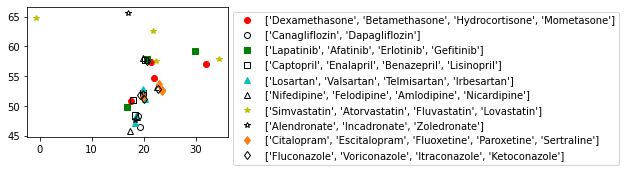

In [42]:
# Drug clustering (Deepwalk-SS)
node_list = ['Dexamethasone', 'Betamethasone', 'Hydrocortisone', 'Mometasone',
'Canagliflozin', 'Dapagliflozin', 
'Lapatinib', 'Afatinib', 'Erlotinib', 'Gefitinib',
'Captopril', 'Enalapril', 'Benazepril', 'Lisinopril',
'Losartan', 'Valsartan', 'Telmisartan', 'Irbesartan',
'Nifedipine', 'Felodipine', 'Amlodipine', 'Nicardipine',
'Simvastatin', 'Atorvastatin', 'Fluvastatin', 'Lovastatin',
'Alendronate', 'Incadronate', 'Zoledronate',
'Citalopram', 'Escitalopram', 'Fluoxetine', 'Paroxetine', 'Sertraline',
'Fluconazole', 'Voriconazole', 'Itraconazole', 'Ketoconazole']

label_true = [0,0,0,0,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,8,8,8,8,8,9,9,9,9] 

Node_Lists = [['Dexamethasone', 'Betamethasone', 'Hydrocortisone', 'Mometasone'],
                ['Canagliflozin', 'Dapagliflozin'],
                ['Lapatinib', 'Afatinib', 'Erlotinib', 'Gefitinib'],
                ['Captopril', 'Enalapril', 'Benazepril', 'Lisinopril'],
                ['Losartan', 'Valsartan', 'Telmisartan', 'Irbesartan'],
                ['Nifedipine', 'Felodipine', 'Amlodipine', 'Nicardipine'],
                ['Simvastatin', 'Atorvastatin', 'Fluvastatin', 'Lovastatin'],
                ['Alendronate', 'Incadronate', 'Zoledronate'],
                ['Citalopram', 'Escitalopram', 'Fluoxetine', 'Paroxetine', 'Sertraline'],
                ['Fluconazole', 'Voriconazole', 'Itraconazole', 'Ketoconazole']]

cluster_df = ClusteringDF(G, node_list, label_true)
tSNEplot(cluster_df, Node_Lists)
# plt.savefig('deepwalk_whole.png', dpi=400,
#             bbox_extra_artists=(lgd,), bbox_inches='tight')